In [33]:
import os
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ntpath

sns.set()

In [34]:
# Testing if Tensorflow GPU is beeing used
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2022-03-14 22:22:25.361239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:22:25.361357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:22:25.361426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:22:25.361558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:22:25.361646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [35]:
#To specify the directory, so we can read and manipulate the DATA and cvs files
datadir = "./IMG"
column_names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = column_names)
#To see the first 5 lines of the created dataFrame
df.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/lucasmirachi/Documents/SelfDrivingCar_Co...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,0.0,0.0,0.0,0.000082
1,/home/lucasmirachi/Documents/SelfDrivingCar_Co...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,0.0,0.0,0.0,0.000082
2,/home/lucasmirachi/Documents/SelfDrivingCar_Co...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,0.0,0.0,0.0,0.000082
3,/home/lucasmirachi/Documents/SelfDrivingCar_Co...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,0.0,0.0,0.0,0.000083
4,/home/lucasmirachi/Documents/SelfDrivingCar_Co...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,/home/lucasmirachi/Documents/SelfDrivingCar_C...,0.0,0.0,0.0,0.000082


In [36]:
#Because we don't want to show the image path itself, we'll cut it using the module ntpath
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [37]:
df['center'] = df['center'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_08_06_10_29_18_914.jpg,left_2020_08_06_10_29_18_914.jpg,right_2020_08_06_10_29_18_914.jpg,0.0,0.0,0.0,0.000082
1,center_2020_08_06_10_29_19_012.jpg,left_2020_08_06_10_29_19_012.jpg,right_2020_08_06_10_29_19_012.jpg,0.0,0.0,0.0,0.000082
2,center_2020_08_06_10_29_19_118.jpg,left_2020_08_06_10_29_19_118.jpg,right_2020_08_06_10_29_19_118.jpg,0.0,0.0,0.0,0.000082
3,center_2020_08_06_10_29_19_220.jpg,left_2020_08_06_10_29_19_220.jpg,right_2020_08_06_10_29_19_220.jpg,0.0,0.0,0.0,0.000083
4,center_2020_08_06_10_29_19_327.jpg,left_2020_08_06_10_29_19_327.jpg,right_2020_08_06_10_29_19_327.jpg,0.0,0.0,0.0,0.000082


In [38]:
print('total data:', len(df))

total data: 5255


<BarContainer object of 25 artists>

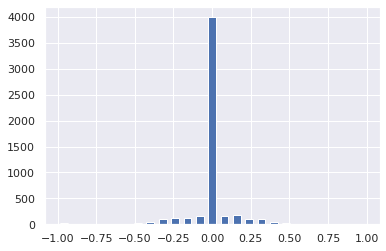

In [39]:
#In order to visualize the distribution, we'll now plot the histogram of steering angles for every set of images, so we can see the distribution and know which steering angles are more frequent in our recording
#To plot the distribution, we'll now plot the values in intervals
num_bins = 25
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(x = center, height = hist, width=0.05)

## Balancing the data

total data: 5255
removed: 3593
remaining: 1662


<BarContainer object of 25 artists>

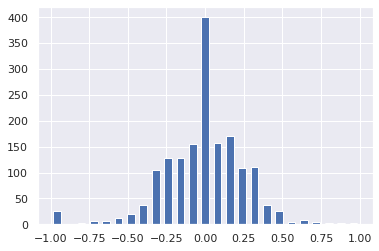

In [40]:
print('total data:', len(df))
#To flatten or samples and cut off the steering values which sum exceeds 400 and make it more uniform
#Edit: Because we were using 200 as samples per bin before, our modeld couldnt drive straight very well, so we'll increase it from 200 to 400
samples_per_bin = 400
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df['steering'])):
    #If the steering angle falls in between two bins, then it bellongs to the interval j
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      list_.append(i)
      #Eventually, this list will contain all the steering numbers from a specific bin. Because our treshold in this project is max 200 steering numbers per bin, we need to reject the exceding ones, and, because the numbers are stored in an array in order, we need to shuffle first (if we just reject the last ones, we may be rejecting information from the end of our track which is bad for our model to predict how to drive properly on the end of the track)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

hist, _ = np.histogram(df['steering'], (num_bins))
plt.bar(x = center, height = hist, width = 0.05)

## Training & Validation Split

In [41]:
#iloc (location i) allows to perform a selection to a row of data from our DataFrame based on a specified index. Example:
print(df.iloc[1])

center      center_2020_08_06_10_29_22_352.jpg
left          left_2020_08_06_10_29_22_352.jpg
right        right_2020_08_06_10_29_22_352.jpg
steering                             -0.156204
throttle                                   1.0
reverse                                    0.0
speed                                  22.9313
Name: 33, dtype: object


In [42]:
def load_img_steering(datadir,dataframe):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2] 
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

#                                           Track  +  /IMG/  = Track/IMG/        
image_paths, steerings = load_img_steering(datadir + '/IMG', df)

In [43]:
image_paths

array(['./IMG/IMG/center_2020_08_06_10_29_21_940.jpg',
       './IMG/IMG/center_2020_08_06_10_29_22_352.jpg',
       './IMG/IMG/center_2020_08_06_10_29_22_461.jpg', ...,
       './IMG/IMG/center_2020_08_06_10_38_14_424.jpg',
       './IMG/IMG/center_2020_08_06_10_38_14_631.jpg',
       './IMG/IMG/center_2020_08_06_10_38_17_930.jpg'], dtype='<U44')

In [44]:
#To split our image_paths and steering arrays into train and test 
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2)
#Checking their sizes (test size is 20% of the total and train is 80%)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1329
Validation Samples: 333


Text(0.5, 1.0, 'Validation set')

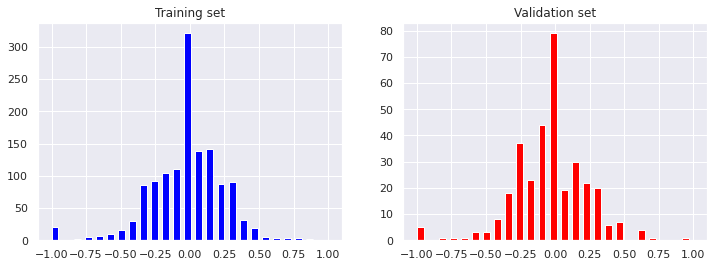

In [45]:
#To check if both sets have normally distributed samples
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Image Preprocessing

In [46]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

def img_preprocess(img):
  #To read the image paths we provided and store the actual image it contains:
  img = mpimg.imread(img)
  #Because we're working with the NVidea Model, it is required to change our image color-space from RGB to YUV
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #Applying 3x3-Kernel GaussianBlur to smooth the image and reduce noie
  img = cv2.GaussianBlur(img, (3,3), 0)
  return img

In [48]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

image = X_train[100]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')

FileNotFoundError: [Errno 2] No such file or directory: './IMG/IMG/center_2020_08_06_10_33_58_081.jpg'

## Creating Image Generator

In [29]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image = image_paths[random_index], steering_angle=steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

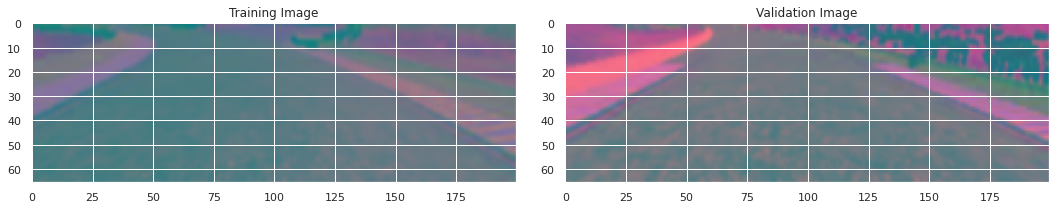

In [30]:
x_train_gen, y_train_gen = next(batch_generator(image_paths=X_train, steering_ang=y_train, batch_size=1, istraining=1))
#Since we're now using validation data, we dont want to aug them, so istraining=0
x_valid_gen, y_valid_gen = next(batch_generator(image_paths=X_valid, steering_ang=y_valid, batch_size=1, istraining=0))

#To plot the data to make sure everything is working as expected
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

---
## Defining the NVIDIA MODEL
Because the goal of this model is to predict the steering angle based on the image, it is a regression type model and a popular model used for behavioural cloning is called the **Nvidia Model** (more information [here](https://drive.google.com/file/d/1g5OCEUGjSYAHu-wbq6muDk8fAyIpVRfG/view?usp=sharing)) which has proven to be effective for behavioural cloning and is also used on real life self driving cars!

The Nvidia Model's architecture is like:
<center><img src="https://miro.medium.com/max/2504/1*2Z_8DB1ybUmRaHUsyi6bSA.png" width="575" height="500"></center>

<center><a href='https://towardsdatascience.com/deep-learning-for-self-driving-cars-7f198ef4cfa2'>Source</a></center>



In [34]:
def nvidia_model():

  model = Sequential()
 
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
 
 
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
 

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
 
  optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4)
  #Because we'll be working with a regression type example, the error metric is going to be the MSE (Mean Squared Error)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [35]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [39]:
history = model.fit_generator(batch_generator(image_paths=X_train, steering_ang=y_train, batch_size=100, istraining=1),
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data= batch_generator(image_paths=X_valid, steering_ang=y_valid, batch_size=100, istraining=0),
                              validation_steps = 200,
                              verbose=1,
                              shuffle=1)

/tmp/ipykernel_28191/401216468.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(image_paths=X_train, steering_ang=y_train, batch_size=100, istraining=1),


Epoch 1/30
100/100 [==============================] - 39s 389ms/step - loss: 0.0675 - val_loss: 0.0482
Epoch 2/30
100/100 [==============================] - 39s 393ms/step - loss: 0.0664 - val_loss: 0.0483
Epoch 3/30
100/100 [==============================] - 39s 395ms/step - loss: 0.0678 - val_loss: 0.0486
Epoch 4/30
100/100 [==============================] - 39s 391ms/step - loss: 0.0647 - val_loss: 0.0450
Epoch 5/30
100/100 [==============================] - 39s 392ms/step - loss: 0.0617 - val_loss: 0.0462
Epoch 6/30
100/100 [==============================] - 39s 391ms/step - loss: 0.0643 - val_loss: 0.0453
Epoch 7/30
100/100 [==============================] - 39s 393ms/step - loss: 0.0618 - val_loss: 0.0456
Epoch 8/30
100/100 [==============================] - 39s 394ms/step - loss: 0.0620 - val_loss: 0.0447
Epoch 9/30
100/100 [==============================] - 39s 392ms/step - loss: 0.0621 - val_loss: 0.0438
Epoch 10/30
100/100 [==============================] - 38s 388ms/step - l

Text(0.5, 0, 'Epoch')

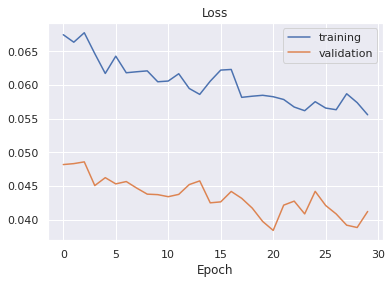

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [71]:
model.save('my_model.h5')